First of all we visualize data from `driving_log.csv` to understand data that we have. It will allows us to analyze and predict model behavior.

steering angle max value is 1.0
steering angle min value is -0.9426954
throttle max value is 0.9855325999999999
throttle min value is 0.0
brake max value is 1.0
brake min value is 0.0
speed max value is 30.709359999999997
speed min value is 0.5024896


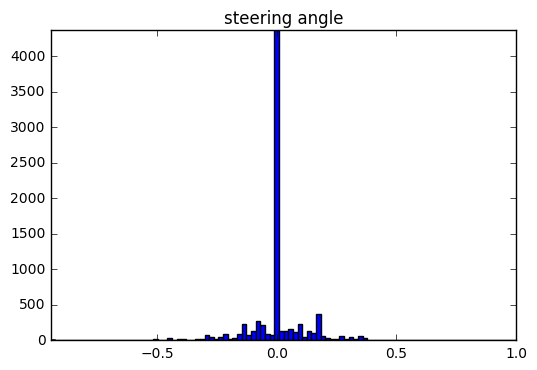

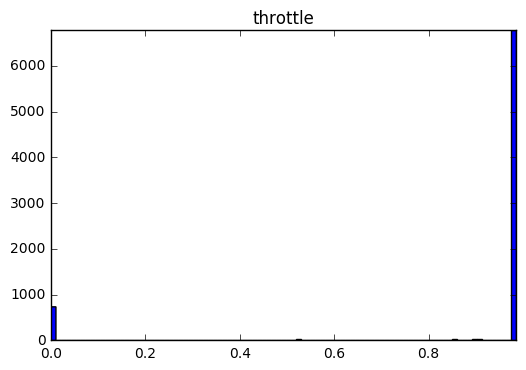

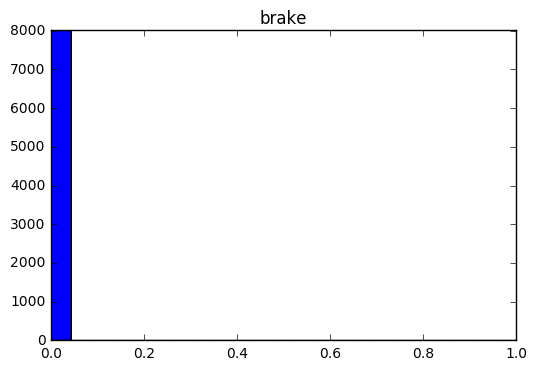

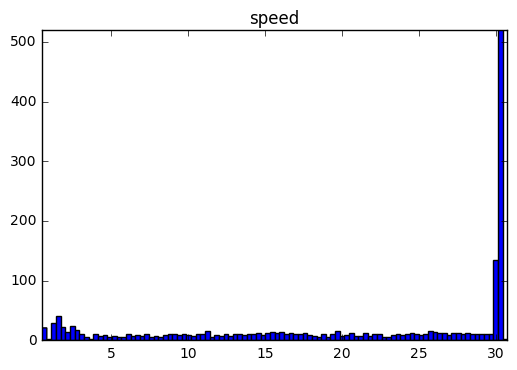

In [1]:
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def draw_data_hist(data, header):
    plt.figure()
    print(header,"max value is", max(data))
    print(header,"min value is", min(data))
    unique_values, counts = np.unique(data, return_counts=True)
    plt.hist(data, bins=min(len(counts), 100))
    plt.title(header)
    plt.axis([min(data), max(data), 0, max(counts)]);

drive_info = read_csv("train_data/driving_log.csv", header=0, usecols=[0,1,2,3,4,5,6]).as_matrix();

draw_data_hist(drive_info[:,3], 'steering angle');
draw_data_hist(drive_info[:,4], 'throttle')
draw_data_hist(drive_info[:,5], 'brake')
draw_data_hist(drive_info[:,6], 'speed')

We see that brake is almost never used.

We see that data with 0 steering angle is a major part of the data. Let's remove it and explore the rest of data. It must be the most frutfull part for the training.

steering angle max value is 1.0
steering angle min value is -0.9426954
throttle max value is 0.9855325999999999
throttle min value is 0.0
brake max value is 1.0
brake min value is 0.0
speed max value is 30.631809999999998
speed min value is 2.124567


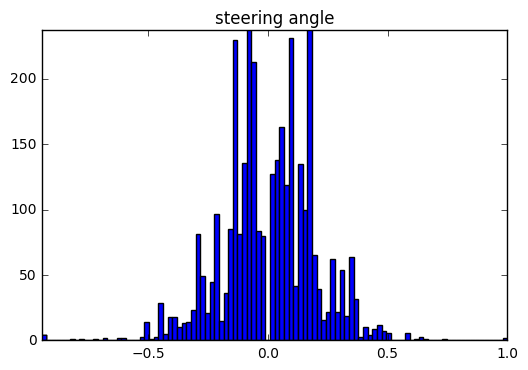

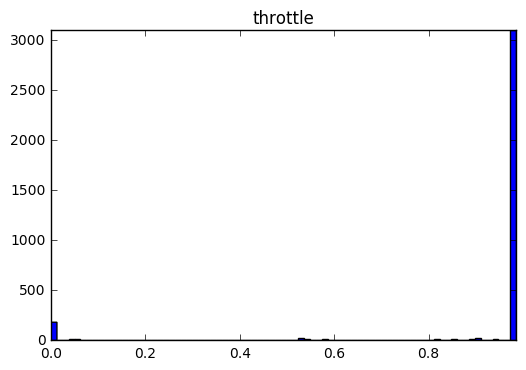

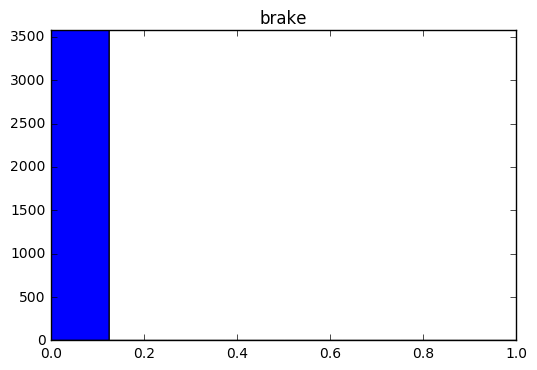

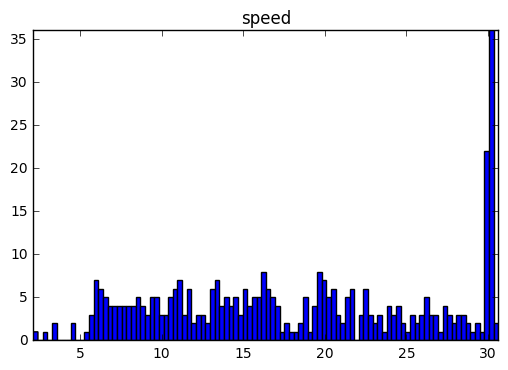

In [2]:
filtered_data = drive_info[abs(drive_info[:,3])>0.01]

draw_data_hist(filtered_data[:,3], 'steering angle');
draw_data_hist(filtered_data[:,4], 'throttle')
draw_data_hist(filtered_data[:,5], 'brake')
draw_data_hist(filtered_data[:,6], 'speed')

Since we have pretrained NN, we do not need a lot of data to train our car. To avoid skewed data we need to reduce amount of zero-angled data. To have more data for turns it is better to flip the images with angle and set an opposite steering_angle. Then we can add zero-angled data in amount of average count per bin.

steering angle max value is 0.004348711
steering angle min value is -0.002791043
throttle max value is 0.9855325999999999
throttle min value is 0.0
brake max value is 0.6174121
brake min value is 0.0
speed max value is 30.709359999999997
speed min value is 0.5024896


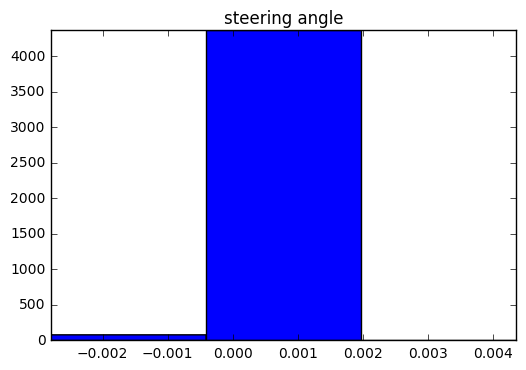

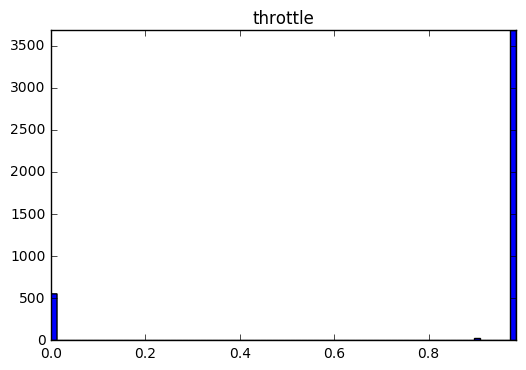

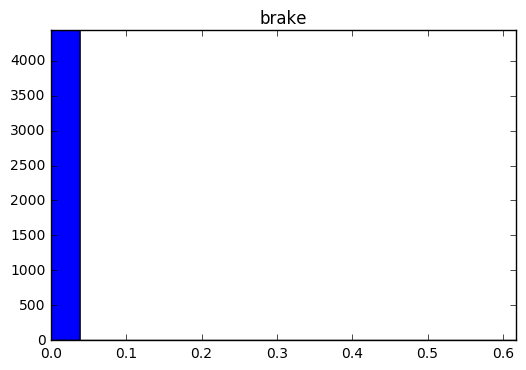

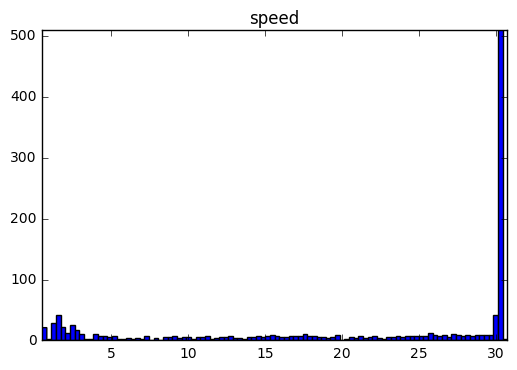

In [3]:
zero_data = drive_info[abs(drive_info[:,3])<=0.01]

draw_data_hist(zero_data[:,3], 'steering angle');
draw_data_hist(zero_data[:,4], 'throttle')
draw_data_hist(zero_data[:,5], 'brake')
draw_data_hist(zero_data[:,6], 'speed')

original data 8036
modified data 24768
modified train angles max value is 1.25
modified train angles min value is -1.1926953999999999


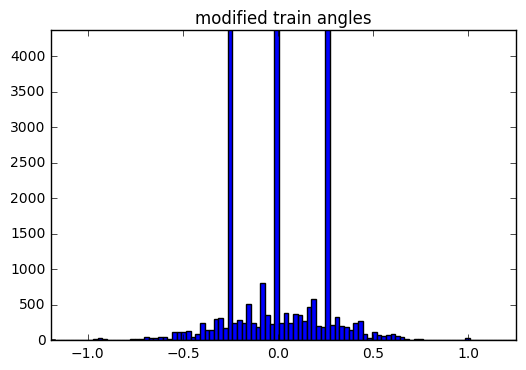

In [4]:
import copy

print('original data', len(drive_info))

modified_data = []

def perturb_angle(angle):
    new_angle = angle* (1 + np.random.uniform(-1, 1)/30.0)
    return min(1, new_angle) if new_angle > 0 else max(-1, new_angle)

def adjust_angle(angle, is_left_img):
    return angle+0.25 if is_left_img else angle-0.25

def adjust_left_angle(angle):
    return adjust_angle(angle, True)

def adjust_right_angle(angle):
    return adjust_angle(angle, False)

def get_flipped_data(line):
    new_line = copy.deepcopy(line)
    new_line[1] = -new_line[1]
    new_line[2] = True
    return new_line

for line in drive_info:
    new_line = copy.deepcopy(line)
    new_line[1] = line[3]
    modified_data.append(new_line)

    new_line = copy.deepcopy(line)
    new_line[0] = new_line[1]
    new_line[1] = adjust_left_angle(line[3])
    modified_data.append(new_line)
    
    new_line = copy.deepcopy(line)
    new_line[0] = new_line[2]
    new_line[1] = adjust_right_angle(line[3])
    modified_data.append(new_line)

# add more samples for steering angle more than 0.5 or less then -0.5

insufficient_data = [data for data in modified_data if abs(float(data[3])) > 0.5]
for line in insufficient_data:
    for i in range(0, 5):
        new_line = copy.deepcopy(line)
        new_line[1] = perturb_angle(line[3])
        modified_data.append(new_line)


modified_data = np.array(modified_data)    
print('modified data', len(modified_data))

draw_data_hist(modified_data[:, 1], 'modified train angles');

train angles max value is 1
train angles min value is 0.0
validation angles max value is 1
validation angles min value is 0.0
trained data 388
validation data 352
train pickle is saved
validation pickle is saved


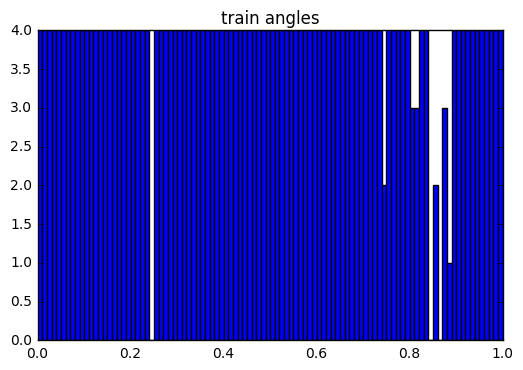

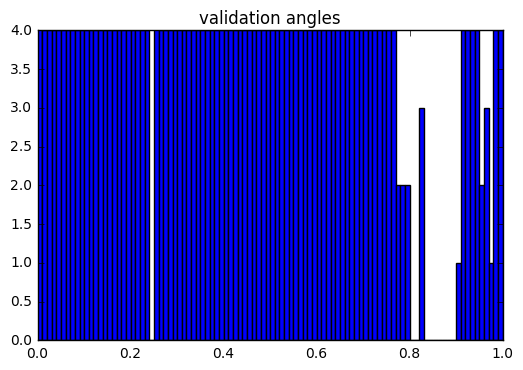

In [5]:
import pickle
import copy
from sklearn.utils import shuffle

train_data=[]
validation_data=[]

step = 0.01
per_step = 4
curent_start = 0.0

def extract_data_from_bin(current_bin):
    validation_bin = []
    
    if len(current_bin) > per_step:
        current_bin = shuffle(current_bin)
        validation_bin = current_bin[per_step:2*per_step]
        for line in validation_bin:
            validation_data.append(line)
        current_bin = current_bin[0:per_step]
    for line in current_bin:
        train_data.append(line)
        
while curent_start<1.0:
    current_bin = [data for data in modified_data if (curent_start < abs(data[1])) and (abs(data[1])<=curent_start+step)]
    extract_data_from_bin(current_bin)
    curent_start = curent_start+step
        
zero_bin = [data for data in modified_data if (data[1]==0.0)]
extract_data_from_bin(zero_bin)

train_data = np.array(train_data)
validation_data = np.array(validation_data)
        
draw_data_hist(abs(train_data[:,1]), 'train angles');
draw_data_hist(abs(validation_data[:,1]), 'validation angles');

print("trained data", len(train_data))
print("validation data", len(validation_data))

# prepare data to save

pickle_data = []
validation_pickle = []

for line in train_data:  
    pickle_data.append({ 'center': line[0], 'angle': line[1] })
    
for line in validation_data:  
    validation_pickle.append({ 'center': line[0], 'angle': line[1] })
    
training_file = 'train.p'
with open(training_file, 'wb') as handle:
    pickle.dump(np.array(pickle_data), handle, protocol=pickle.HIGHEST_PROTOCOL)

print("train pickle is saved")
    
validation_file = 'validation.p'
with open(validation_file, 'wb') as handle:
    pickle.dump(np.array(validation_pickle), handle, protocol=pickle.HIGHEST_PROTOCOL)

print("validation pickle is saved")

Using TensorFlow backend.


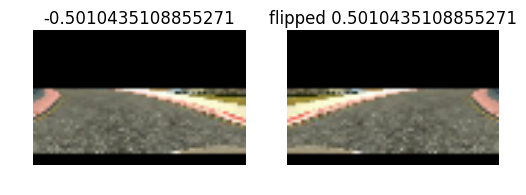

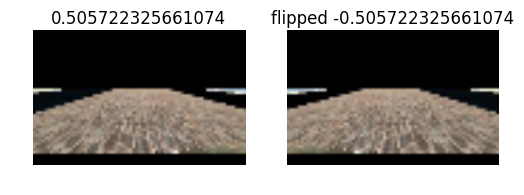

In [6]:
import cv2
import os
import matplotlib.image as mpimg
import numpy as np
from model import read_image
from image_processing import preprocess_image


folder_path = 'train_data'

def draw_from_image_data(image_path, prefix, angle):
    image = read_image(image_path)
    
    fig = plt.figure()
    
    subplot = plt.subplot(1, 2, 1)
    subplot.imshow(image)
    subplot.axis('off')
    subplot.set_title(prefix+str(angle))
    
    flipped_image = cv2.flip(image, 1)
    title = 'flipped '+prefix+str(-angle)
    
    subplot = plt.subplot(1, 2, 2)
    subplot.imshow(flipped_image)
    subplot.axis('off')
    subplot.set_title(title)
    
def draw_image(image_data):
    draw_from_image_data(image_data[0], '', image_data[1])

left_image = train_data[train_data[:,1]<-0.5][0,:]
draw_image(left_image)

right_image = train_data[train_data[:,1]>0.5][0,:]
draw_image(right_image)

2 of -0.0383331
2 of 0.0383331
generate 32 images
generate 32 images


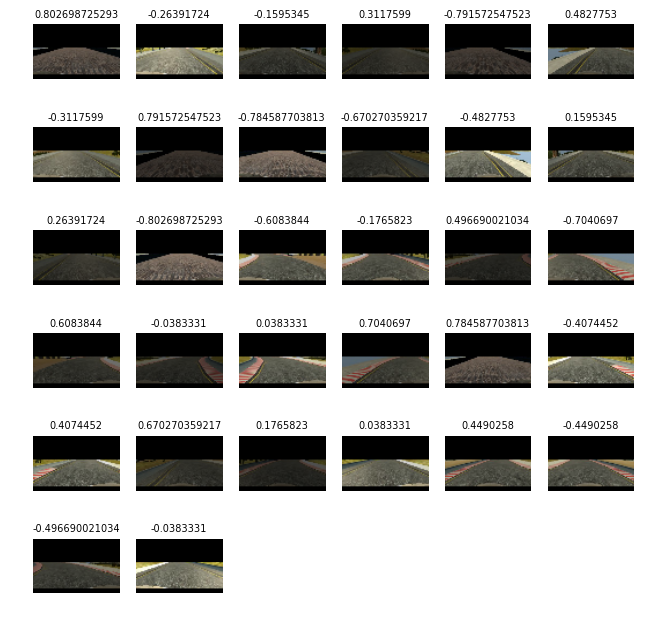

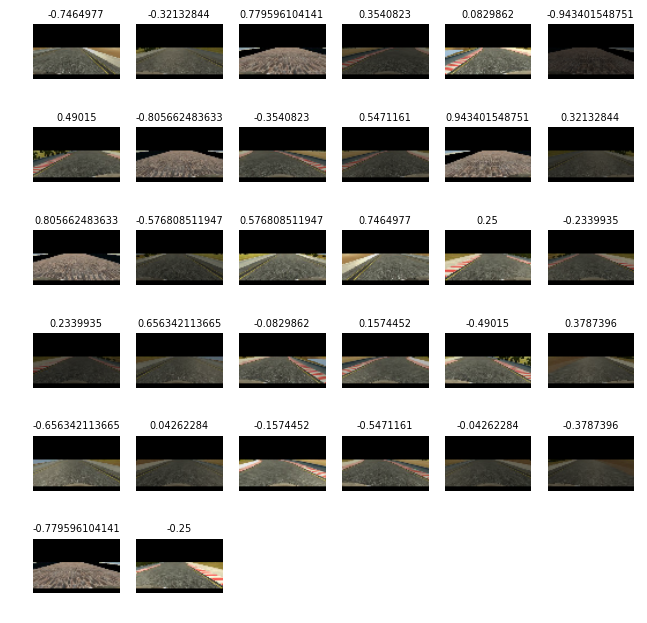

In [15]:
from model import generate_steering_angle

def display_test_data(img_data):
    count = 0
    for X, Y in generate_steering_angle(img_data, batch_size=32):
        fig = plt.figure(figsize=(6,6))
        fig.subplots_adjust(bottom=0.0, left=0.0, top = 1.0, right=1.0)
        unique_angles, angle_counts = np.unique(Y, return_counts=True)
        for i in range(0, len(angle_counts)):
            if angle_counts[i] > 1:
                print(angle_counts[i], 'of', unique_angles[i])
                
        print('generate', len(X), 'images')
        for i in range(0, len(X)):
            subplot = plt.subplot(6, 6, i+1)
            subplot.imshow(X[i])
            subplot.axis('off')
            subplot.set_title(Y[i], fontsize = 7)

        count = count+1
        if (count > 1):
            return

display_test_data(pickle_data)

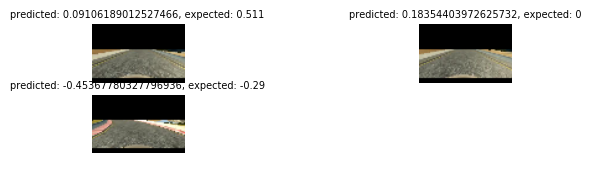

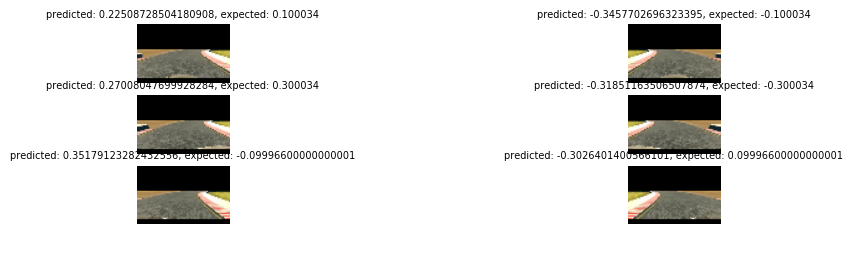

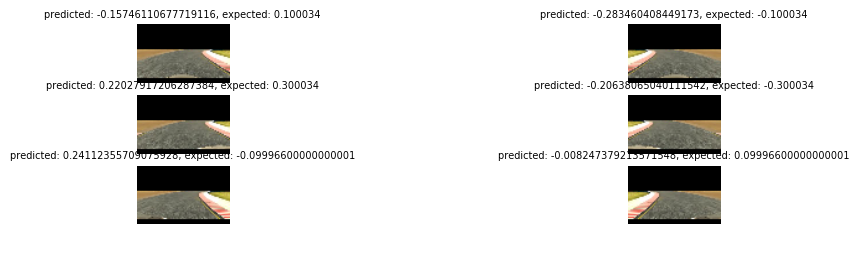

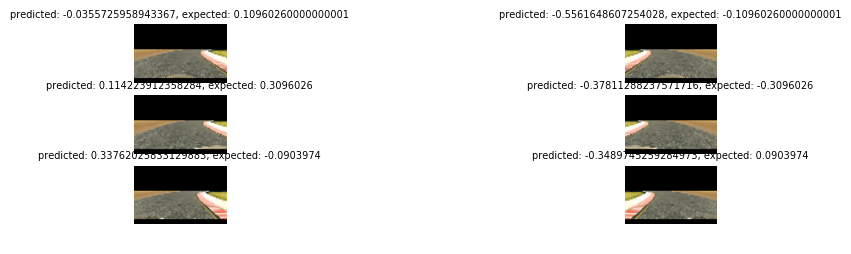

In [26]:
from keras.models import load_model
    
model = load_model('model.h5')

X_custom=['IMG/center_2016_12_01_13_34_39_571.jpg', 'IMG/center_2016_12_01_13_34_42_305.jpg','IMG/center_2016_12_01_13_36_44_575.jpg']     
Y_custom=[0.511,0,-0.29]

def predict_angle(path):
    image_array = read_image(path)
    transformed_image_array = image_array[None, :, :, :]
    flipped_image = cv2.flip(image_array, 1)
    return float(model.predict(transformed_image_array, batch_size=1)), image_array, float(model.predict(flipped_image[None, :, :, :], batch_size=1)), flipped_image
    
def draw_image(image, angle, expected_angle, i):
    subplot = plt.subplot(3, 2, i)
    subplot.imshow(image)
    subplot.axis('off')
    title = 'predicted: {}, expected: {}'.format(angle, expected_angle)
    subplot.set_title(title, fontsize = 7)
    
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(bottom=0.0, left=0.0, top = 1.0, right=2.0)
for i in range(0,3):
    prediction, image,_,_ = predict_angle(X_custom[i])
    draw_image(image, prediction, Y_custom[i], i+1)

tough_data = [ { 'start': 'IMG/center_2016_12_01_13_34_05_133.jpg', 'end': 'IMG/center_2016_12_01_13_34_05_335.jpg' } ]
tough_bin = [data for data in drive_info if (tough_data[0]['start'] <= data[0]) and (data[0] <= tough_data[0]['end'])]

# analyze tough data
for line in tough_bin:
    fig = plt.figure(figsize=(3,2))
    fig.subplots_adjust(bottom=0.0, left=0.0, top = 1.0, right=3.0)
    angle, image, flipped_angle, flipped_image = predict_angle(line[0])
    draw_image(image, angle, line[3], 1)
    draw_image(flipped_image, flipped_angle, -line[3], 2)
    
    angle, image, flipped_angle, flipped_image = predict_angle(line[1])
    expected_angle = line[3]+0.2
    draw_image(image, angle, expected_angle, 3)
    draw_image(flipped_image, flipped_angle, -expected_angle, 4)
    
    angle, image, flipped_angle, flipped_image = predict_angle(line[2])
    expected_angle = line[3]-0.2
    draw_image(image, angle, expected_angle, 5)
    draw_image(flipped_image, flipped_angle, -expected_angle, 6)   